In [75]:
bigdir = '/Users/eric/Documents/CDS465/'

pydir = bigdir + 'pysrc/'
datadir = bigdir + 'data/'
popdir = bigdir + 'population/'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append( pydir )

import Main

import zombie as zmb
import population, nomad, island
import scipy.integrate as sin
import scipy.ndimage as ndi 

### NewMoveZombie

In [ ]:
def NewMoveZombies( E, zombiesdf, adults, MoveCeil=5, MoveNorm=10 ):
    # group and count
    adults[['ilocv','iloch']] = adults[['locv','loch']].astype(int)
    gadults = adults.groupby( ['ilocv','iloch']).count()
    gadults = gadults.reset_index()
    # make map
    ctmap = np.zeros(E.isle['terrain'].shape)
    x = gadults['iloch'].values
    y = gadults['ilocv'].values
    cts = gadults['pid'].values
    ctmap[y,x] = cts

    # map and gradient
    ctmap = ndi.gaussian_filter( ctmap, 12 )
    dx, dy = np.gradient( ctmap )

    # normalize to Zombie speed
    v = np.array( (dx.min(), dx.max(), dy.min(), dy.max()) )
    v = np.abs( v )

    #print('v', v)

    #normalize partial derivatives 
    mx = v.max()
    dx = dx * MoveNorm/mx
    dy = dy * MoveNorm/mx

    #try q1; q3 of computed derivatives
    dx_vals, dy_vals = dx.flatten(), dy.flatten()
    dx_q1, dx_q3 = np.percentile(dx_vals, 25), np.percentile(dx_vals, 75)
    dy_q1, dy_q3 = np.percentile(dy_vals, 25), np.percentile(dy_vals, 75)
    dx_quartile_mask = (dx < dx_q1) | (dx > dx_q3)
    dy_quartile_mask = (dy < dy_q1) | (dy > dy_q3)
    dx[~dx_quartile_mask], dy[~dy_quartile_mask] = 0, 0

    #intoduce a random movement component
    MinMove = MoveCeil * 0.005
    zero_mask = (dx == 0) & (dy == 0)
    random_kick_x = np.random.uniform(-MinMove, MinMove, size=dx.shape)
    random_kick_y = np.random.uniform(-MinMove, MinMove, size=dy.shape)

    dx[zero_mask] = random_kick_x[zero_mask]
    dy[zero_mask] = random_kick_y[zero_mask]

    #set derivatives to move ceiling if they are less | more
    dx = np.maximum( dx, -MoveCeil ) 
    dx = np.minimum( dx, MoveCeil )
    dy = np.maximum( dy, -MoveCeil )
    dy = np.minimum( dy, MoveCeil )

    # get destination from map: does not use erratic
    zombiesdf[['ilocv','iloch']] = zombiesdf[['locv','loch']].astype(int)
    x = zombiesdf['iloch']
    y = zombiesdf['ilocv']
    zombiesdf['dv'] = dy[y,x] #### problem zone; Solution: intoduce a random movement component
    zombiesdf['dh'] = dx[y,x]

    """print(E.month)
    print(zombiesdf[['dh', 'dv']].head(7))"""

    # move zombie
    zombiesdf['locv'] += zombiesdf['dv']
    zombiesdf['loch'] += zombiesdf['dh']
    return zombiesdf
    

### ZEvolve Function

In [106]:
def ZEvolve2(E:Main, Nmonths:int, addpeep:int, dometh:int, lim:int, MoveCeil:int, LMeal:int, migrate=False, new_MoveZombie = True) -> tuple[list[int], list, list]:
    cct, zct, zombiesdf, mgs, zmgs = [], [], zmb.MakeZombies(E, lim), [], []
    for i in range(Nmonths):
        E.month += 1
        population.OneMonth(E, dometh, migrate=migrate)
        if addpeep>0: nomad.Immigrate(E, addpeep, dometh)

        #plot populations
        if (i == 0) | ((i+1) % 25 == 0):
            subpop = E.persondf.loc[E.persondf['death']==-1]
            mg = island.IslandPopulation( E.isle, subpop )
            mgs.append(mg[1200-110: 1200+110, 1400-110:1400+110])
        """if (i+1) % 25 == 0:
            subpop = E.persondf.loc[E.persondf['death']==-1]
            mg = island.IslandPopulation( E.isle, subpop )
            mgs.append(mg[1200-110: 1200+110, 1400-110:1400+110])"""

        # zombie stuff
        adults = zmb.AdultsIlocs(E)
        if new_MoveZombie:
            zombiesdf = NewMoveZombies( E, zombiesdf, adults, MoveCeil, MoveNorm=MoveCeil*2)
        else:
            zombiesdf = zmb.MoveZombies( E, zombiesdf, adults, MoveCeil, MoveNorm=MoveCeil*2)
        zombiesdf = zmb.FeedZombies( E, zombiesdf, adults, 8, LMeal)

        if (i == 0) | ((i+1) % 25 == 0):
            z1 = zombiesdf['lastmeal'] < LMeal
            zombsvh = zombiesdf.loc[z1][['locv', 'loch']].astype(int).values
            zombsvh = zombsvh[np.all((zombsvh > 0) & (zombsvh < 2048), axis=1)]
            H, x_edge, y_edge = np.histogram2d(x=zombsvh[:,0],
                                                y=zombsvh[:,1],
                                                bins=2048,
                                                range=[[0, 2048], [0, 2048]] # Ensure bins cover the data range
                                            )
            zmgs.append(H.T)

        ct_zomb = (zombiesdf['lastmeal']<=LMeal).sum()
        zct.append(ct_zomb)
        cct.append(len(E.persondf.loc[E.persondf['death']==-1]))

        if ct_zomb==0: break #zombiesdf = zmb.MakeZombies(E, 1) 

    targ = [lim, MoveCeil, LMeal]

    return (targ, cct, zct, mgs, zmgs)

### run Function

In [107]:
#n_years, n_zombies, move_rad, lmeal
def run(targs: list) -> tuple[list, list, list]:
    """
    Try 20 years (240 months); 
    This function accepts a list of paramters to test the ZEvolve function in order to tune the params for zombies to persist in this model

    inpts:
        targs (list): list of parameters to tune ZEvolve;
            formated as:
                [n_zombies, move_rad, lmeal] 
    opts:
        tuple[list, list, list]
            the parameters for the model
            the first list is the population count
            the second list is the zombie count
    """
    # Reload Population 
    G = Main.Realm( datadir )
    G.ReadAll( popdir + 'pop3_7.db') #### Replace with your population for testing!!!
    
    #run test
    begin = G.month
    (targ, cct, zct, mgs, zmgs) = ZEvolve2(G, 20*12, 0, 0, targs[0], MoveCeil = targs[1], LMeal = targs[2], migrate=False )
    """ 
    plt.figure( figsize=(6,6))
    plt.plot(cct, zct)
    plt.title(label=f'Population Count vs Zombie Count Over {G.month - begin} months')
    plt.xlabel(xlabel='Human Population')
    plt.ylabel('Zombie Count')
    plt.show()
    """

    #plots
    #zombie location
    fig, axs = plt.subplots(1,len(zmgs), figsize=(3*len(zmgs),1*len(zmgs)))
    for i in range(len(zmgs)):
        elm_size = 11
        kernel = np.ones((elm_size, elm_size), dtype=bool)
        zmg = ndi.binary_dilation(zmgs[i], structure=kernel).astype(np.uint8)
        axs[i].imshow(zmg, cmap='gray')
        axs[i].set_title(f'Zombies at month {i*25}')
    plt.tight_layout()
    plt.show()

    #population at city (1200,1400)
    fig, axs = plt.subplots(1,len(mgs), figsize=(3*len(mgs),1*len(mgs)))
    for i in range(len(mgs)):
        axs[i].imshow(mgs[i])
        axs[i].set_title(f'Population at (1200, 1400) at month {i*25}')
    plt.tight_layout()
    plt.show()

    #test run output data
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
    ax1.plot(cct, zct)
    ax1.set_title(f'Human vs Zmb Over {G.month - begin} months')
    ax1.set_xlabel('Human Population')
    ax1.set_ylabel(f'Zombie Population with params={targ}')
    ax1.set_xlim((10000,15000))
    ax1.set_ylim((0,1750))

    #ax2.plot(range(1,len(cct)+1), cct, color='gold', label='Human Count')
    ax2.plot(range(1,len(zct)+1), zct, color='g', label='Zombie Count')
    ax2.set_title(f'Human and Zmb Over {G.month - begin} months')
    ax2.set_xlabel(f'Time (Months); ends at month={len(cct)}')
    ax2.set_ylabel('Population Count')
    ax2.set_xlim((0,240))
    #ax2.set_yscale('log')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    print(f"from begining {begin} to end {G.month}, {G.month-begin} months have elapsed")
    print(f"The targs where: initial zombies={targ[0]}, movement_radius={targ[1]}, and last_meal={targ[2]}")

    return (targ, cct, zct)

### Test

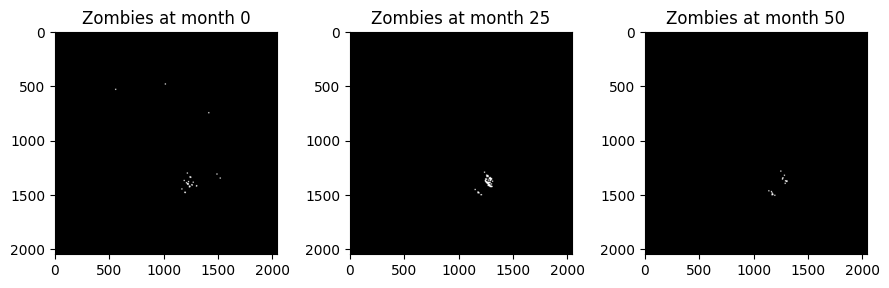

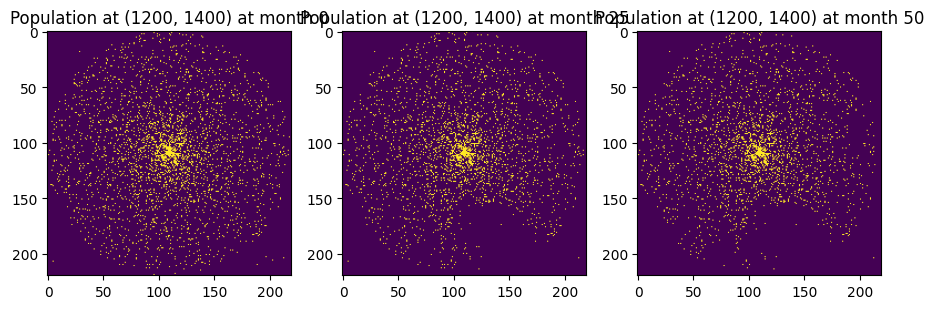

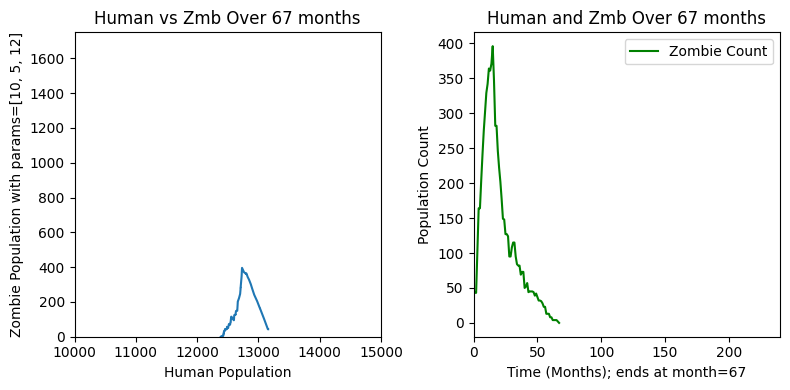

from begining 8320 to end 8387, 67 months have elapsed
The targs where: initial zombies=10, movement_radius=5, and last_meal=12


In [108]:
(tar0, cct0, zct0) = run([10,5,12])